In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [25]:
pd.set_option('display.max_columns', None)

In [2]:
previous_application = help_tool.csv_download(r'Archive\home-credit-default-risk\previous_application.csv')
help_tool.first_look(previous_application)

Dataset has 1670214 observations and 37 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
AMT_ANNUITY,float64,372235,22.3
AMT_APPLICATION,float64,0,0.0
AMT_CREDIT,float64,1,0.0
AMT_DOWN_PAYMENT,float64,895844,53.6
AMT_GOODS_PRICE,float64,385515,23.1
WEEKDAY_APPR_PROCESS_START,object,0,0.0
HOUR_APPR_PROCESS_START,int64,0,0.0


In [3]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def convert_flags(df):
    for col in df.columns:
        if col.startswith('FLAG'):
            df[col] = df[col].replace({'Y': 1, 'N': 0}).astype(int)
            df[col] = df[col].infer_objects(copy=False)
    return df

previous_application = convert_flags(previous_application)

In [5]:
object_columns = previous_application.select_dtypes(include=['object']).columns.tolist()

In [6]:
help_tool.first_look(previous_application[object_columns])

Dataset has 1670214 observations and 15 features
Columns with all empty values []
Dataset has 1544404 duplicates


,dtypes,"Null values, Count","Null values, %"
NAME_CONTRACT_TYPE,object,0,0.0
WEEKDAY_APPR_PROCESS_START,object,0,0.0
NAME_CASH_LOAN_PURPOSE,object,0,0.0
NAME_CONTRACT_STATUS,object,0,0.0
NAME_PAYMENT_TYPE,object,0,0.0
CODE_REJECT_REASON,object,0,0.0
NAME_TYPE_SUITE,object,820405,49.1
NAME_CLIENT_TYPE,object,0,0.0
NAME_GOODS_CATEGORY,object,0,0.0
NAME_PORTFOLIO,object,0,0.0


Duplicated application

In [10]:
previous_application[previous_application['NFLAG_LAST_APPL_IN_DAY'] != 1]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
207,1033218,191478,Consumer loans,7300.530,39465.0,35505.0,3960.0,39465.0,WEDNESDAY,7,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-686.0,-536.0,-566.0,-551.0,0.0
277,2770539,185661,Revolving loans,6750.000,0.0,180000.0,NaN,NaN,THURSDAY,11,...,Consumer electronics,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
482,2319125,218182,Revolving loans,22500.000,337500.0,900000.0,NaN,337500.0,TUESDAY,12,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
1279,2629070,206111,Cash loans,28316.115,495000.0,553806.0,NaN,495000.0,WEDNESDAY,11,...,XNA,36.0,middle,Cash X-Sell: middle,365243.0,-732.0,318.0,-372.0,-366.0,1.0
1335,2187571,379247,Revolving loans,4500.000,0.0,135000.0,NaN,NaN,SATURDAY,17,...,XNA,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668046,1762724,325916,Revolving loans,22500.000,540000.0,540000.0,NaN,540000.0,SATURDAY,12,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
1668506,1341321,152116,Revolving loans,7875.000,0.0,180000.0,NaN,NaN,THURSDAY,10,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1668507,2468578,343076,Revolving loans,6750.000,0.0,157500.0,NaN,NaN,WEDNESDAY,13,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1669593,2063794,225535,Revolving loans,38250.000,0.0,315000.0,NaN,NaN,WEDNESDAY,9,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
previous_application[previous_application['SK_ID_CURR'] == 191478]#[['FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY']]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
207,1033218,191478,Consumer loans,7300.530,39465.0,35505.0,3960.0,39465.0,WEDNESDAY,7,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-686.0,-536.0,-566.0,-551.0,0.0
1090453,1905389,191478,Consumer loans,16331.670,79515.0,83452.5,0.0,79515.0,FRIDAY,13,...,Furniture,6.0,high,POS industry with interest,365243.0,-1954.0,-1804.0,-1804.0,-1797.0,0.0
1403129,1515098,191478,Consumer loans,21602.835,220410.0,220410.0,0.0,220410.0,TUESDAY,9,...,Consumer electronics,12.0,low_normal,POS household with interest,365243.0,-141.0,189.0,365243.0,365243.0,0.0


In [15]:
previous_application[previous_application['SK_ID_CURR'] == 185661].sort_values(by='WEEKDAY_APPR_PROCESS_START')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
227724,1546641,185661,Consumer loans,6563.835,131521.5,140854.5,13945.5,131521.5,FRIDAY,12,...,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-2659.0,-1969.0,-1999.0,-1995.0,1.0
1607655,2306609,185661,Cash loans,55472.535,1147500.0,1230808.5,NaN,1147500.0,SATURDAY,8,...,XNA,30.0,low_normal,Cash X-Sell: low,365243.0,-832.0,38.0,-172.0,-168.0,1.0
277,2770539,185661,Revolving loans,6750.000,0.0,180000.0,NaN,NaN,THURSDAY,11,...,Consumer electronics,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
348373,2318645,185661,Consumer loans,27447.255,258039.0,247050.0,25807.5,258039.0,THURSDAY,9,...,Construction,10.0,low_normal,POS industry with interest,365243.0,-1926.0,-1656.0,-1716.0,-1708.0,0.0
1216415,2229583,185661,Revolving loans,6750.000,0.0,135000.0,NaN,NaN,THURSDAY,12,...,Consumer electronics,0.0,XNA,Card Street,-2620.0,-2564.0,365243.0,-1651.0,-19.0,0.0
131641,1340667,185661,Consumer loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,15,...,XNA,NaN,XNA,POS other with interest,NaN,NaN,NaN,NaN,NaN,NaN
164099,2046119,185661,Consumer loans,19172.925,425592.0,425592.0,0.0,425592.0,TUESDAY,8,...,Consumer electronics,24.0,low_action,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN
355288,2256311,185661,Cash loans,45517.815,1129500.0,1344294.0,NaN,1129500.0,TUESDAY,15,...,XNA,54.0,low_normal,Cash X-Sell: low,365243.0,-479.0,1111.0,365243.0,365243.0,1.0
1495154,2235905,185661,Consumer loans,19275.075,425592.0,425592.0,0.0,425592.0,TUESDAY,10,...,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-877.0,-187.0,-487.0,-483.0,0.0


In [20]:
previous_application['Duplicated_Hour'] = previous_application.drop(columns='SK_ID_PREV').duplicated()
previous_application['Duplicated_Day'] = previous_application.drop(columns=['SK_ID_PREV', 'HOUR_APPR_PROCESS_START']).duplicated()
previous_application['Duplicated'] = previous_application.drop(columns=['SK_ID_PREV', 'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START']).duplicated()

In [17]:
previous_application[previous_application.drop(columns='SK_ID_PREV').duplicated() == True]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1418,2124598,154046,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,13,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1757,1729146,273220,Consumer loans,NaN,17091.0,17091.0,NaN,17091.0,FRIDAY,15,...,Consumer electronics,NaN,XNA,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
2467,2213779,210395,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
3585,2442765,185043,Cash loans,15270.3,135000.0,143910.0,NaN,135000.0,TUESDAY,8,...,XNA,12.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
4305,1095567,426852,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,16,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670125,2097911,380917,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1670130,2026104,357412,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,22,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1670152,2785958,174686,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,8,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1670176,2489754,104479,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
previous_application[previous_application['Duplicated_Day'] == True]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,Duplicated,Duplicated_Hour,Duplicated_Day
6107,1426246,351578,Consumer loans,NaN,58896.0,58896.0,0.0,58896.0,SATURDAY,12,1,1,0.0,NaN,NaN,XAP,Unused offer,-137,Cash through the bank,CLIENT,NaN,Repeater,Computers,XNA,XNA,Country-wide,5,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
17363,2743276,336389,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,8,1,1,NaN,NaN,NaN,XNA,Canceled,-206,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,0,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
19161,1882243,371165,Cash loans,NaN,0.0,0.0,NaN,NaN,SUNDAY,14,1,1,NaN,NaN,NaN,XNA,Canceled,-359,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
19748,2829295,123001,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,10,1,1,NaN,NaN,NaN,XNA,Canceled,-277,XNA,XAP,NaN,Refreshed,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
20974,1511368,330547,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,10,1,1,NaN,NaN,NaN,XNA,Canceled,-220,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670120,2494083,101748,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,19,1,1,NaN,NaN,NaN,XNA,Refused,-427,XNA,HC,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True
1670121,1637907,101748,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,19,1,1,NaN,NaN,NaN,XNA,Refused,-427,XNA,HC,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
1670122,1942990,242431,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,13,1,1,NaN,NaN,NaN,XNA,Canceled,-231,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
1670170,2815031,214184,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,14,1,1,NaN,NaN,NaN,XNA,Canceled,-90,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True


In [28]:
previous_application[previous_application['SK_ID_CURR'] == 214184].sort_values(by='SK_ID_PREV')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,Duplicated,Duplicated_Hour,Duplicated_Day
853835,1482305,214184,Consumer loans,9565.200,89284.5,98712.0,0.0,89284.5,THURSDAY,10,1,1,0.000000,NaN,NaN,XAP,Approved,-600,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,10,Connectivity,12.0,low_normal,POS mobile without interest,365243.0,-569.0,-239.0,-359.0,-352.0,0.0,False,False,False
641857,2047887,214184,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,13,1,1,NaN,NaN,NaN,XNA,Canceled,-90,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1626307,2327281,214184,Consumer loans,5155.515,36000.0,45067.5,0.0,36000.0,WEDNESDAY,14,1,1,0.000000,NaN,NaN,XAP,Approved,-1525,Cash through the bank,XAP,"Spouse, partner",Refreshed,Audio/Video,POS,XNA,Stone,50,Consumer electronics,12.0,high,POS household with interest,365243.0,-1494.0,-1164.0,-1344.0,-1339.0,0.0,False,False,False
1604161,2513063,214184,Consumer loans,3320.685,33210.9,29889.0,3321.9,33210.9,SUNDAY,15,1,1,0.108936,NaN,NaN,XAP,Refused,-2669,Cash through the bank,SCO,NaN,Repeater,Consumer Electronics,POS,XNA,Stone,120,Consumer electronics,10.0,low_normal,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1503716,2601303,214184,Consumer loans,3064.230,26545.5,26257.5,2655.0,26545.5,TUESDAY,14,1,1,0.100010,NaN,NaN,XAP,Approved,-2821,Cash through the bank,XAP,Family,Repeater,Mobile,POS,XNA,Stone,504,Consumer electronics,12.0,high,POS household with interest,365243.0,-2790.0,-2460.0,-2460.0,-2452.0,1.0,False,False,False
1670170,2815031,214184,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,14,1,1,NaN,NaN,NaN,XNA,Canceled,-90,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Contact center,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True
1615332,2831869,214184,Cash loans,12963.780,180000.0,232159.5,NaN,180000.0,TUESDAY,15,1,1,NaN,NaN,NaN,XNA,Approved,-1168,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,low_normal,Cash Street: low,365243.0,-1135.0,-445.0,-715.0,-709.0,0.0,False,False,False


In [21]:
previous_application[previous_application['SK_ID_CURR'] == 154046]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,Duplicated,Duplicated_Hour,Duplicated_Day
1417,2293674,154046,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,13,...,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1418,2124598,154046,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,13,...,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
265307,1804976,154046,Cash loans,NaN,0.0,0.0,NaN,NaN,THURSDAY,11,...,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
394335,1294829,154046,Cash loans,14588.055,180000.0,215640.0,NaN,180000.0,MONDAY,13,...,Cash Street: high,365243.0,-517.0,533.0,-457.0,-450.0,1.0,False,False,False
852227,2464912,154046,Consumer loans,29869.200,172341.0,104841.0,67500.0,172341.0,FRIDAY,14,...,POS household with interest,365243.0,-2760.0,-2670.0,-2670.0,-2662.0,0.0,False,False,False
873482,1063945,154046,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,13,...,Cash,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1124907,2748827,154046,Revolving loans,22500.000,450000.0,450000.0,NaN,450000.0,THURSDAY,12,...,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1124908,2585931,154046,Revolving loans,22500.000,450000.0,450000.0,NaN,450000.0,THURSDAY,12,...,Card X-Sell,-635.0,-593.0,365243.0,365243.0,365243.0,0.0,False,False,False


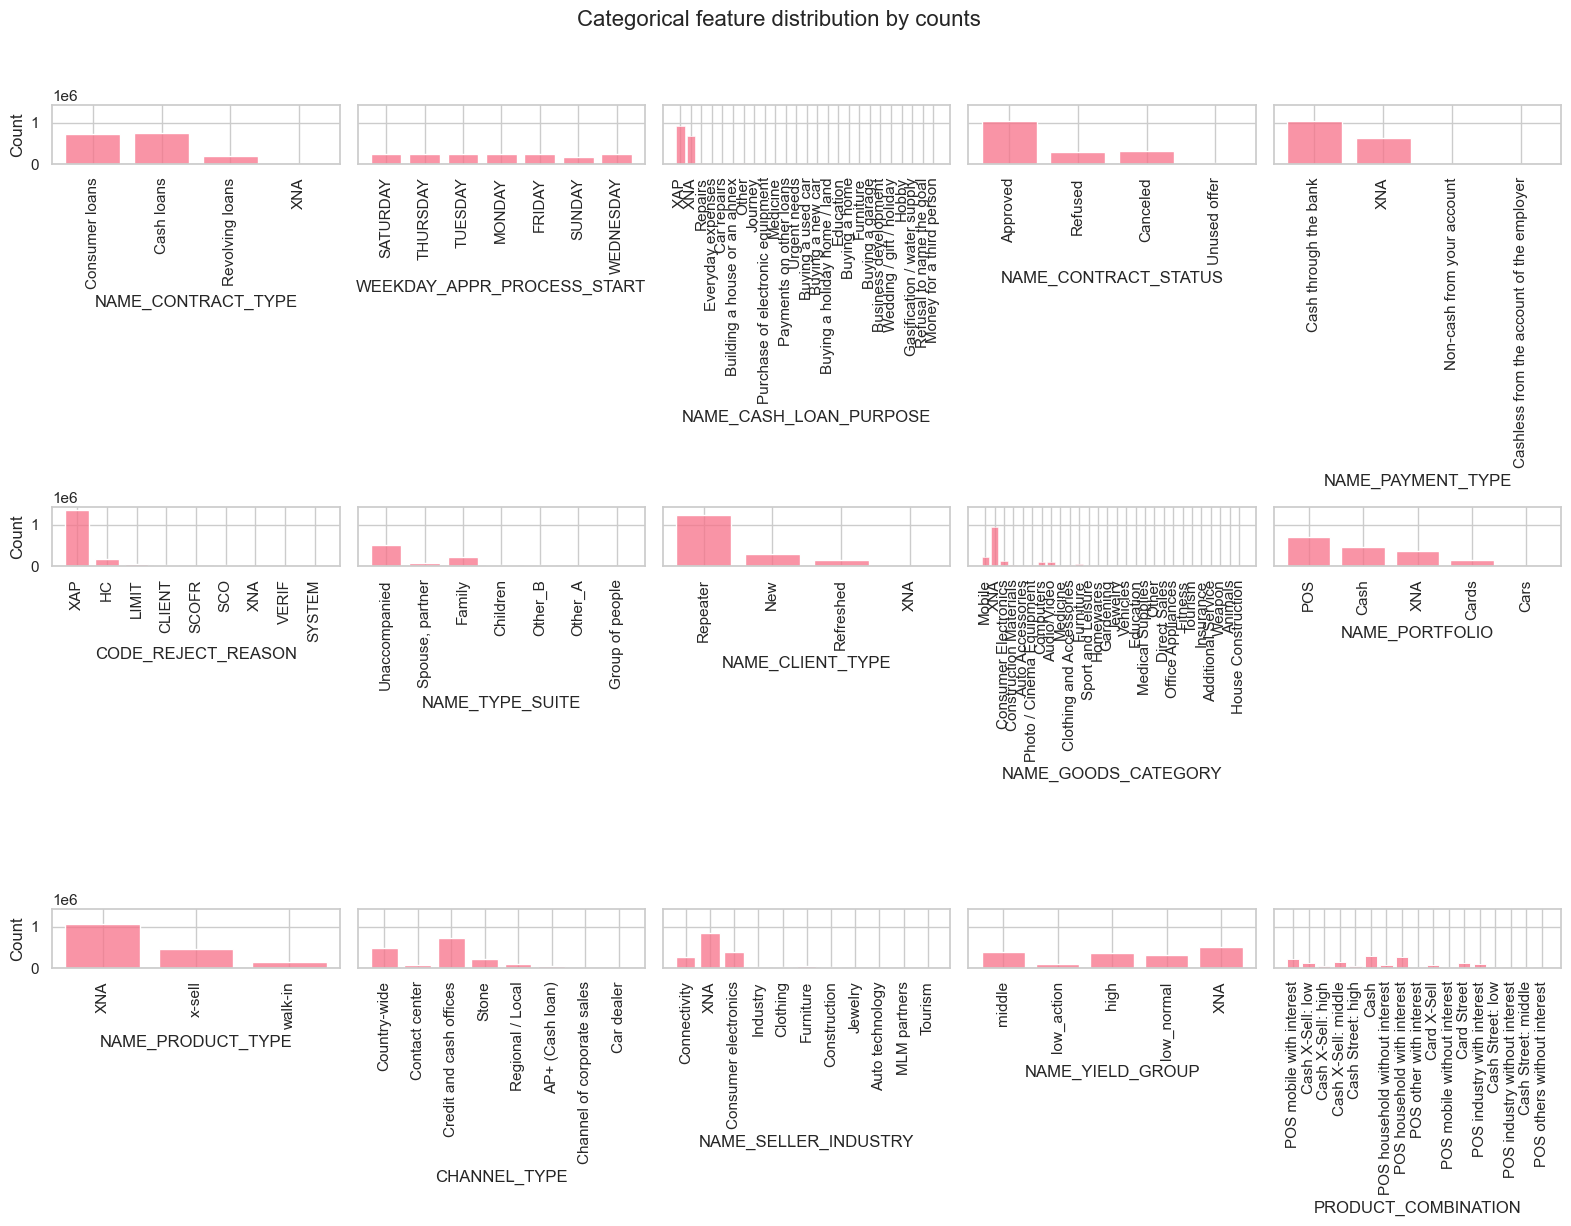

In [51]:
object_columns = previous_application.select_dtypes(include=['object']).columns.tolist()



fig, axes = plt.subplots(3, 5, figsize=(16, 12), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.histplot(data=previous_application, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], #hue='Target', 
                 legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

In [52]:
def weekday_encoding(df, feature):

    weekday_mapping = {'monday': 0, 'tuesday': 1, 'wednesday': 2, 'thursday': 3, 'friday': 4, 'saturday': 5, 'sunday': 6}

    df[feature] = df[feature].str.lower()
    df[feature] = df[feature].map(weekday_mapping)

    # Apply sine transformation
    df[feature] = np.sin(2 * np.pi * df[feature] / 7).astype(float)
    return df[feature]

previous_application['WEEKDAY_APPR_PROCESS_START'] = weekday_encoding(previous_application, 'WEEKDAY_APPR_PROCESS_START')

In [53]:
def accompanied(df):
    df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].apply(
        lambda x: 'Other' if x != 'Unaccompanied' and pd.notna(x) else x
    )

    df.loc[df['NAME_TYPE_SUITE']== 'Unaccompanied', 'Accompanied'] = 0
    df.loc[df['NAME_TYPE_SUITE']== 'Other', 'Accompanied'] = 1

    df.drop(columns='NAME_TYPE_SUITE', inplace=True)

    return df

accompanied(previous_application)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,Accompanied
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,-0.974928,15,...,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,NaN
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,0.433884,11,...,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,0.781831,11,...,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,0.000000,7,...,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,NaN
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,0.433884,9,...,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,0.974928,12,...,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,NaN
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,0.781831,15,...,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,0.000000,12,...,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,1.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,0.974928,9,...,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,1.0


In [54]:
previous_application['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

# Unused offer + Canceled  (NAME_CONTRACT_STATUS)

In [55]:
previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Canceled']['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         268591
Revolving loans     45854
Consumer loans       1559
XNA                   315
Name: count, dtype: int64

In [56]:
previous_application[['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON']].value_counts().reset_index(name='count').sort_values(by=['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON'])

,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,count
0,Approved,XAP,1036773
10,Approved,XNA,8
1,Canceled,XAP,316319
2,Refused,HC,175231
3,Refused,LIMIT,55680
4,Refused,SCO,37467
6,Refused,SCOFR,12811
9,Refused,SYSTEM,717
8,Refused,VERIF,3535
11,Refused,XAP,1


In [57]:
previous_application.loc[previous_application['NAME_CONTRACT_STATUS'] == 'Approved', 'CODE_REJECT_REASON'] = 'Approved'
previous_application.loc[previous_application['NAME_CONTRACT_STATUS'] == 'Unused offer', 'CODE_REJECT_REASON'] = 'Unused offer'

In [58]:
previous_application['NAME_CONTRACT_STATUS'].value_counts() / 1036781 * 100

NAME_CONTRACT_STATUS
Approved        100.000000
Canceled         30.509722
Refused          28.036586
Unused offer      2.549815
Name: count, dtype: float64

In [59]:
previous_application_canceled = previous_application.copy()
previous_application_canceled.drop(columns=['CODE_REJECT_REASON', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'], inplace=True)
previous_application_canceled.drop(columns=['SK_ID_PREV', 'SK_ID_CURR'], inplace=True)

In [60]:
previous_application_canceled['Canceled_Unused'] = 0
previous_application_canceled.loc[previous_application_canceled['NAME_CONTRACT_STATUS'].isin(['Canceled', 'Unused offer']), 'Canceled_Unused'] = 1

previous_application_canceled.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

In [61]:
previous_application_canceled['Canceled_Unused'].value_counts() / previous_application_canceled['Canceled_Unused'].value_counts().max() * 100

Canceled_Unused
0    100.000000
1     25.820383
Name: count, dtype: float64

In [62]:
y = previous_application_canceled['Canceled_Unused']
X = previous_application_canceled.drop(columns=['Canceled_Unused'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Define the model
model = LGBMClassifier(**params, n_estimators=100)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [64]:
# # Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.8932933419801125
accuracy: 0.9693422703065174
recall: 0.9657761353179183
ROC AUC: 0.9897077086810524


In [65]:
# Extract the preprocessing step and get feature names
preprocessor.fit(X_train)
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numerical_features + onehot_columns.tolist()

# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Combine feature names and their importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': all_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                    Feature  Importance
10                            DAYS_DECISION         757
13                              Accompanied         200
4                           AMT_GOODS_PRICE         154
92     CHANNEL_TYPE_Credit and cash offices         152
12                              CNT_PAYMENT         113
..                                      ...         ...
53          NAME_GOODS_CATEGORY_Audio/Video           0
52              NAME_GOODS_CATEGORY_Animals           0
51   NAME_GOODS_CATEGORY_Additional Service           0
50                     NAME_CLIENT_TYPE_XNA           0
128                 PRODUCT_COMBINATION_nan           0

[129 rows x 2 columns]


In [66]:
feature_importance_df.head(20)

,Feature,Importance
10,DAYS_DECISION,757
13,Accompanied,200
4,AMT_GOODS_PRICE,154
92,CHANNEL_TYPE_Credit and cash offices,152
12,CNT_PAYMENT,113
90,CHANNEL_TYPE_Contact center,107
11,SELLERPLACE_AREA,100
42,NAME_CASH_LOAN_PURPOSE_XNA,94
49,NAME_CLIENT_TYPE_Repeater,87
3,AMT_DOWN_PAYMENT,86


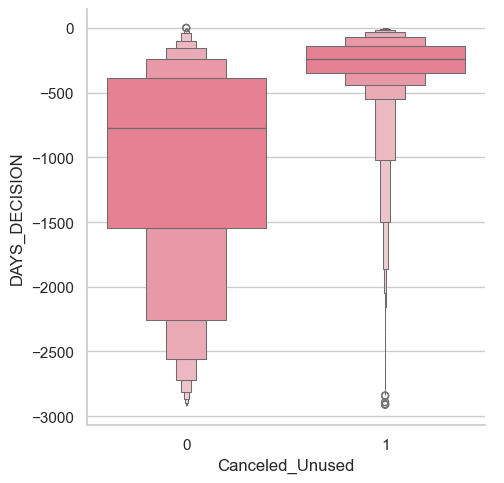

In [75]:
sns.catplot(previous_application_canceled[['DAYS_DECISION', 'Canceled_Unused']], x='Canceled_Unused', y='DAYS_DECISION', kind="boxen")
plt.show()